In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

%run helpFunction.ipynb

2024-05-26 02:18:51.235044: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 02:18:51.293900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 02:18:52.231745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


\begin{table}
\caption{Test Klassifikations Metriken}
\label{tab:model_performance}
\begin{tabular}{llllr}
\toprule
Modell & Accuracy & Precision & Recall & F1-Score \\
\midrule
InceptionV3 & 82% & 83% & 82% & 82.000000 \\
DeiT & 81% & 81% & 82% & 81.000000 \\
Hybridmodel - ViT & DeiT & 80% & 80% & 81% & 80.000000 \\
Vision Transformer Lite & 79% & 79% & 79% & 79.000000 \\
Hybridmodel - ViT Lite & DeiT & 74% & 75% & 74% & 74.000000 \\
VisionTransformer & 73% & 72% & 72% & 72.000000 \\
Basic CNN & 62% & 67% & 61% & 58.000000 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_3179058/671559329.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Modell').apply(lambda x: x.nlargest(1, 'F1-Score')).reset_index(drop=True)


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2024-05-26 02:18:54.345633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 72831 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


1 Physical GPUs, 1 Logical GPUs


In [3]:
# Konfiguration
image_size = (250, 250)
batch_size = 32

In [4]:
path_with_sign = 'data/y'
path_without_sign = 'data/n'

In [5]:
def load_images_from_folder(folder, label, target_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Fehler beim Laden des Bildes {img_path}: {e}")
    return np.array(images), np.array(labels)

In [6]:
images_with_sign, labels_with_sign = load_images_from_folder(path_with_sign, 1, image_size)
images_without_sign, labels_without_sign = load_images_from_folder(path_without_sign, 0, image_size)

In [7]:
all_images = np.concatenate((images_with_sign, images_without_sign), axis=0)
all_labels = np.concatenate((labels_with_sign, labels_without_sign), axis=0)

In [8]:
all_images /= 255.0
all_images

array([[[[0.49019608, 0.5019608 , 0.33333334],
         [0.4862745 , 0.5019608 , 0.3647059 ],
         [0.5176471 , 0.53333336, 0.42745098],
         ...,
         [0.53333336, 0.53333336, 0.5254902 ],
         [0.5294118 , 0.5294118 , 0.5294118 ],
         [0.5254902 , 0.5254902 , 0.5176471 ]],

        [[0.43529412, 0.43529412, 0.29411766],
         [0.4392157 , 0.44313726, 0.31764707],
         [0.46666667, 0.4862745 , 0.36862746],
         ...,
         [0.5176471 , 0.5176471 , 0.50980395],
         [0.52156866, 0.52156866, 0.52156866],
         [0.5137255 , 0.5137255 , 0.5058824 ]],

        [[0.45490196, 0.44313726, 0.32156864],
         [0.45882353, 0.45490196, 0.33333334],
         [0.45882353, 0.47058824, 0.34901962],
         ...,
         [0.5137255 , 0.5137255 , 0.5058824 ],
         [0.5019608 , 0.50980395, 0.49019608],
         [0.5058824 , 0.5137255 , 0.49411765]],

        ...,

        [[0.44313726, 0.42745098, 0.41568628],
         [0.48235294, 0.47058824, 0.4509804 ]

In [9]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [10]:
train_images.shape, test_images.shape, validation_images.shape

((931, 250, 250, 3), (292, 250, 250, 3), (233, 250, 250, 3))

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

In [12]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)
validation_generator = test_datagen.flow(validation_images, validation_labels, batch_size=batch_size)

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


/home/chandrsangee@edu.local/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,872,449 (52.92 MB)

 Trainable params: 13,872,449 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_images) // batch_size
)

Epoch 1/100


/home/chandrsangee@edu.local/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716682742.595775 3179345 service.cc:145] XLA service 0x7fe8fc0060b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716682742.595870 3179345 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-05-26 02:19:02.631990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-26 02:19:02.820050: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN vers

 1/29 ━━━━━━━━━━━━━━━━━━━━ 3:05 7s/step - accuracy: 0.6875 - loss: 0.6867

I0000 00:00:1716682745.825432 3179345 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/29 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.4941 - loss: 2.2847

I0000 00:00:1716682751.796606 3179351 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 68 bytes spill stores, 68 bytes spill loads



29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 246ms/step - accuracy: 0.4875 - loss: 1.9271 - val_accuracy: 0.5268 - val_loss: 0.6844
Epoch 2/100
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6250 - loss: 0.6751

2024-05-26 02:19:12.763240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:19:12.763338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:19:12.763375: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:19:12.763407: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
/home/chandrsangee@edu.local/miniconda3/envs/tf/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your 

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6250 - loss: 0.6751 - val_accuracy: 0.6667 - val_loss: 0.6803
Epoch 3/100


2024-05-26 02:19:13.273099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:19:13.273200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:19:13.273234: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:19:13.273265: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.5161 - loss: 0.6896 - val_accuracy: 0.5357 - val_loss: 0.6719
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.6250 - loss: 0.6433 - val_accuracy: 0.4444 - val_loss: 0.7294
Epoch 5/100


2024-05-26 02:19:22.764136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:19:22.764307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:19:22.772365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:19:22.772421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:19:22.772445: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:19:22.772468: I tensorflow/core/framework/local_ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.5842 - loss: 0.6810 - val_accuracy: 0.4732 - val_loss: 0.7236
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4062 - loss: 0.7629 - val_accuracy: 0.3333 - val_loss: 0.8025
Epoch 7/100


2024-05-26 02:19:32.156274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:19:32.156367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:19:32.156405: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:19:32.156436: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:19:32.182099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:19:32.182187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.5116 - loss: 0.7005 - val_accuracy: 0.4777 - val_loss: 0.7070
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.3750 - loss: 0.7729 - val_accuracy: 0.5556 - val_loss: 0.6441
Epoch 9/100


2024-05-26 02:19:41.475987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:19:41.476066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:19:41.476098: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:19:41.476128: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:19:41.483550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:19:41.483624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.5844 - loss: 0.6782 - val_accuracy: 0.5134 - val_loss: 0.6808
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.4688 - loss: 0.6934 - val_accuracy: 1.0000 - val_loss: 0.6612
Epoch 11/100


2024-05-26 02:19:50.973984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:19:50.974172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:19:50.981811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:19:50.981839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:19:50.981853: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:19:50.981865: I tensorflow/core/framework/local_ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.5632 - loss: 0.6857 - val_accuracy: 0.5312 - val_loss: 1.1408
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.5312 - loss: 1.0063 - val_accuracy: 0.3333 - val_loss: 0.7804
Epoch 13/100


2024-05-26 02:20:00.449775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:00.449976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:20:00.457630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:00.457682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.5928 - loss: 0.6685 - val_accuracy: 0.6071 - val_loss: 0.6535
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.5938 - loss: 0.6759 - val_accuracy: 0.5556 - val_loss: 0.7133
Epoch 15/100


2024-05-26 02:20:09.846319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:09.846396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:20:09.846426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:20:09.846458: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:20:09.854972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:09.855004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.6334 - loss: 0.6560 - val_accuracy: 0.5491 - val_loss: 0.6994
Epoch 16/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.5625 - loss: 0.6193 - val_accuracy: 0.5556 - val_loss: 0.5516
Epoch 17/100


2024-05-26 02:20:19.340983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:19.341066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:20:19.341099: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:20:19.341133: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:20:19.349998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:19.350048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.6254 - loss: 0.6843 - val_accuracy: 0.5848 - val_loss: 0.6511
Epoch 18/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.7500 - loss: 0.5904 - val_accuracy: 0.6667 - val_loss: 0.5677
Epoch 19/100


2024-05-26 02:20:28.751528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:28.751720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:20:28.759813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:28.759876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:20:28.759905: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:20:28.759947: I tensorflow/core/framework/local_ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.6532 - loss: 0.6431 - val_accuracy: 0.5580 - val_loss: 0.6948
Epoch 20/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.5625 - loss: 0.6518 - val_accuracy: 0.5556 - val_loss: 0.6541
Epoch 21/100


2024-05-26 02:20:38.152184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:38.152275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:20:38.160816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:38.160899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:20:38.160933: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:20:38.160963: I tensorflow/core/framework/local_ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.6202 - loss: 0.6723 - val_accuracy: 0.5938 - val_loss: 0.6555
Epoch 22/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.6562 - loss: 0.6492 - val_accuracy: 0.6667 - val_loss: 0.7217
Epoch 23/100


2024-05-26 02:20:47.653793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:47.653888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:20:47.653922: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:20:47.653961: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:20:47.662052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:47.662113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.6100 - loss: 0.6642 - val_accuracy: 0.6027 - val_loss: 0.6648
Epoch 24/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.4688 - loss: 0.7080 - val_accuracy: 0.4444 - val_loss: 0.7240
Epoch 25/100


2024-05-26 02:20:57.004386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:57.004439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:20:57.004455: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:20:57.004467: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:20:57.011982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:20:57.012012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.6223 - loss: 0.6577 - val_accuracy: 0.6161 - val_loss: 0.6445
Epoch 26/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.7188 - loss: 0.5627 - val_accuracy: 0.5556 - val_loss: 0.7154
Epoch 27/100


2024-05-26 02:21:06.691266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:06.691331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:21:06.699474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:06.699523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.6549 - loss: 0.6524 - val_accuracy: 0.6652 - val_loss: 0.6019
Epoch 28/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6667 - loss: 0.8858 - val_accuracy: 0.5556 - val_loss: 0.7104
Epoch 29/100


2024-05-26 02:21:16.061468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:16.061512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:21:16.061525: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:21:16.061534: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:21:16.069144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:16.069174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.6745 - loss: 0.6214 - val_accuracy: 0.6830 - val_loss: 0.6101
Epoch 30/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.6875 - loss: 0.6186 - val_accuracy: 0.3333 - val_loss: 0.7132
Epoch 31/100


2024-05-26 02:21:25.441176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:25.441270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:21:25.449103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:25.449134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:21:25.449147: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:21:25.449157: I tensorflow/core/framework/local_ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.6481 - loss: 0.6341 - val_accuracy: 0.6295 - val_loss: 0.6164
Epoch 32/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.6250 - loss: 0.6483 - val_accuracy: 0.6667 - val_loss: 0.6506
Epoch 33/100


2024-05-26 02:21:34.873237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:34.873332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:21:34.873367: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:21:34.873404: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:21:34.881401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:34.881467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.6736 - loss: 0.6143 - val_accuracy: 0.6250 - val_loss: 0.6439
Epoch 34/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.7188 - loss: 0.5711 - val_accuracy: 0.7778 - val_loss: 0.4301
Epoch 35/100


2024-05-26 02:21:44.382434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:44.382758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:21:44.391135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:44.391197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:21:44.391225: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:21:44.391254: I tensorflow/core/framework/local_ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.6547 - loss: 0.6421 - val_accuracy: 0.6518 - val_loss: 0.6112
Epoch 36/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.6875 - loss: 0.5770 - val_accuracy: 0.7778 - val_loss: 0.5603
Epoch 37/100


2024-05-26 02:21:54.322560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:54.322612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:21:54.331879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:21:54.331912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:21:54.331927: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:21:54.331939: I tensorflow/core/framework/local_ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.6664 - loss: 0.6225 - val_accuracy: 0.7009 - val_loss: 0.5583
Epoch 38/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.7188 - loss: 0.5663 - val_accuracy: 0.7778 - val_loss: 0.4980
Epoch 39/100


2024-05-26 02:22:03.823006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:03.823082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:22:03.831362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:03.831424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:22:03.831454: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:22:03.831482: I tensorflow/core/framework/local_ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.7174 - loss: 0.5815 - val_accuracy: 0.6518 - val_loss: 0.6106
Epoch 40/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.7188 - loss: 0.6907 - val_accuracy: 0.8889 - val_loss: 0.5567
Epoch 41/100


2024-05-26 02:22:13.230567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:13.230620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:22:13.239116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:13.239191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:22:13.239222: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:22:13.239251: I tensorflow/core/framework/local_ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.6404 - loss: 0.6300 - val_accuracy: 0.7054 - val_loss: 0.5661
Epoch 42/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.6875 - loss: 0.6289 - val_accuracy: 0.6667 - val_loss: 0.5804
Epoch 43/100


2024-05-26 02:22:22.762707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:22.762785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:22:22.762816: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:22:22.762863: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:22:22.771106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:22.771146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.7295 - loss: 0.5453 - val_accuracy: 0.7232 - val_loss: 0.5504
Epoch 44/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.6250 - loss: 0.5883 - val_accuracy: 0.6667 - val_loss: 0.4904
Epoch 45/100


2024-05-26 02:22:32.357396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:32.357453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:22:32.357469: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:22:32.357478: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:22:32.365822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:32.365855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.6978 - loss: 0.5827 - val_accuracy: 0.7589 - val_loss: 0.5274
Epoch 46/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.6875 - loss: 0.5857 - val_accuracy: 0.4444 - val_loss: 0.7589
Epoch 47/100


2024-05-26 02:22:41.823909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:41.823995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:22:41.824021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:22:41.824048: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:22:41.831612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:41.831690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.7064 - loss: 0.5631 - val_accuracy: 0.6920 - val_loss: 0.5919
Epoch 48/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.7812 - loss: 0.5200 - val_accuracy: 0.6667 - val_loss: 0.6644
Epoch 49/100


2024-05-26 02:22:51.377149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:51.377207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:22:51.377226: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:22:51.377243: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:22:51.386604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:22:51.386670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.7256 - loss: 0.5516 - val_accuracy: 0.7455 - val_loss: 0.5347
Epoch 50/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.6562 - loss: 0.6094 - val_accuracy: 0.7778 - val_loss: 0.5268
Epoch 51/100


2024-05-26 02:23:00.748014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:00.748091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:23:00.748120: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:23:00.748150: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:23:00.756042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:00.756103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.7121 - loss: 0.5679 - val_accuracy: 0.6205 - val_loss: 0.6446
Epoch 52/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.6250 - loss: 0.6442 - val_accuracy: 0.5556 - val_loss: 0.6375
Epoch 53/100


2024-05-26 02:23:10.488877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:10.488952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:23:10.488982: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:23:10.489014: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:23:10.497046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:10.497076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.6847 - loss: 0.5761 - val_accuracy: 0.7455 - val_loss: 0.5008
Epoch 54/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.8125 - loss: 0.5385 - val_accuracy: 0.8889 - val_loss: 0.5124
Epoch 55/100


2024-05-26 02:23:20.040072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:20.040149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:23:20.040181: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:23:20.040212: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:23:20.048099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:20.048182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.7288 - loss: 0.5378 - val_accuracy: 0.7634 - val_loss: 0.4954
Epoch 56/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.7188 - loss: 0.5814 - val_accuracy: 0.8889 - val_loss: 0.3533
Epoch 57/100


2024-05-26 02:23:29.607220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:29.607316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:23:29.607356: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:23:29.607396: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:23:29.615655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:29.615734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.7691 - loss: 0.5087 - val_accuracy: 0.7054 - val_loss: 0.5418
Epoch 58/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.6250 - loss: 0.6143 - val_accuracy: 0.5556 - val_loss: 0.5403
Epoch 59/100


2024-05-26 02:23:38.958860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:38.958939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:23:38.958969: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:23:38.958998: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:23:38.966910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:38.966992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.7555 - loss: 0.5366 - val_accuracy: 0.7679 - val_loss: 0.4720
Epoch 60/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.6044 - val_accuracy: 1.0000 - val_loss: 0.2613
Epoch 61/100


2024-05-26 02:23:48.423747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:48.423831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:23:48.423862: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:23:48.423893: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:23:48.458832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:48.458915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.7670 - loss: 0.5111 - val_accuracy: 0.7589 - val_loss: 0.5105
Epoch 62/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.8438 - loss: 0.4429 - val_accuracy: 0.5556 - val_loss: 0.6983
Epoch 63/100


2024-05-26 02:23:57.899521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:57.899605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-05-26 02:23:57.907948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:23:57.908023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:23:57.908053: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:23:57.908083: I tensorflow/core/framework/local_ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.7471 - loss: 0.5448 - val_accuracy: 0.7679 - val_loss: 0.4952
Epoch 64/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.8438 - loss: 0.4575 - val_accuracy: 0.8889 - val_loss: 0.3806
Epoch 65/100


2024-05-26 02:24:07.354303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:07.354392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:24:07.354422: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:24:07.354453: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:24:07.362705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:07.362766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.7395 - loss: 0.5352 - val_accuracy: 0.8125 - val_loss: 0.4621
Epoch 66/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.9062 - loss: 0.3405 - val_accuracy: 0.7778 - val_loss: 0.4656
Epoch 67/100


2024-05-26 02:24:16.724618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:16.724697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:24:16.724743: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:24:16.724774: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:24:16.732823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:16.732883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.7442 - loss: 0.5259 - val_accuracy: 0.7188 - val_loss: 0.5416
Epoch 68/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.8125 - loss: 0.4409 - val_accuracy: 0.7778 - val_loss: 0.4539
Epoch 69/100


2024-05-26 02:24:24.363283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:24.363357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:24:24.363388: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:24:24.363417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:24:24.371249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:24.371305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.7494 - loss: 0.5278 - val_accuracy: 0.7098 - val_loss: 0.5366
Epoch 70/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.7500 - loss: 0.5012 - val_accuracy: 0.7778 - val_loss: 0.4419
Epoch 71/100


2024-05-26 02:24:33.852137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:33.852242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:24:33.852279: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:24:33.852320: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:24:33.861638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:33.861712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.7620 - loss: 0.5020 - val_accuracy: 0.7857 - val_loss: 0.4602
Epoch 72/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.7188 - loss: 0.5083 - val_accuracy: 0.5556 - val_loss: 0.5410
Epoch 73/100


2024-05-26 02:24:43.391547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:43.391635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:24:43.391690: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:24:43.391738: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:24:43.399549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:43.399622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.7235 - loss: 0.5297 - val_accuracy: 0.7857 - val_loss: 0.4714
Epoch 74/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.6210 - val_accuracy: 0.7778 - val_loss: 0.4830
Epoch 75/100


2024-05-26 02:24:52.953129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:52.953228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:24:52.953260: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:24:52.953291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:24:52.962946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:24:52.963027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.7700 - loss: 0.4899 - val_accuracy: 0.7366 - val_loss: 0.5135
Epoch 76/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.5312 - loss: 0.7215 - val_accuracy: 0.3333 - val_loss: 0.7819
Epoch 77/100


2024-05-26 02:25:02.395614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:02.395747: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:25:02.395812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:25:02.403653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:02.403738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:25:02.403767: I tensorflow/core/framework/local_ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.7385 - loss: 0.5251 - val_accuracy: 0.8170 - val_loss: 0.4506
Epoch 78/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.7188 - loss: 0.4720 - val_accuracy: 0.6667 - val_loss: 0.5566
Epoch 79/100


2024-05-26 02:25:11.834619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:11.834693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:25:11.834722: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:25:11.834753: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:25:11.841835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:11.841896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.7487 - loss: 0.4974 - val_accuracy: 0.7679 - val_loss: 0.4830
Epoch 80/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.7188 - loss: 0.5951 - val_accuracy: 0.7778 - val_loss: 0.4766
Epoch 81/100


2024-05-26 02:25:21.456642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:21.456720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:25:21.456752: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:25:21.456783: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:25:21.464021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:21.464097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.7607 - loss: 0.4928 - val_accuracy: 0.7723 - val_loss: 0.4969
Epoch 82/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.8125 - loss: 0.3995 - val_accuracy: 0.5556 - val_loss: 0.8261
Epoch 83/100


2024-05-26 02:25:31.218550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:31.218642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:25:31.218677: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:25:31.218716: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:25:31.226170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:31.226240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.7219 - loss: 0.5160 - val_accuracy: 0.7188 - val_loss: 0.5270
Epoch 84/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.7500 - loss: 0.4687 - val_accuracy: 0.5556 - val_loss: 0.8366
Epoch 85/100


2024-05-26 02:25:40.627951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:40.628037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:25:40.628069: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:25:40.628101: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:25:40.637658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:40.637724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.7544 - loss: 0.5225 - val_accuracy: 0.7991 - val_loss: 0.4736
Epoch 86/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.7500 - loss: 0.4806 - val_accuracy: 0.6667 - val_loss: 0.5082
Epoch 87/100


2024-05-26 02:25:50.192797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:50.192878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:25:50.192911: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:25:50.192945: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:25:50.201518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:50.201602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.7680 - loss: 0.4705 - val_accuracy: 0.7723 - val_loss: 0.4960
Epoch 88/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.8438 - loss: 0.3333 - val_accuracy: 0.7778 - val_loss: 0.3945
Epoch 89/100


2024-05-26 02:25:59.528649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:59.528727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:25:59.528757: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:25:59.528787: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:25:59.536829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:25:59.536892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.7650 - loss: 0.4802 - val_accuracy: 0.7768 - val_loss: 0.4514
Epoch 90/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.7188 - loss: 0.4504 - val_accuracy: 0.4444 - val_loss: 0.9661
Epoch 91/100


2024-05-26 02:26:08.936470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:08.936546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:26:08.936579: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:26:08.936610: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:26:08.944280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:08.944341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.8032 - loss: 0.4274 - val_accuracy: 0.7991 - val_loss: 0.4531
Epoch 92/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.5938 - loss: 0.5385 - val_accuracy: 0.7778 - val_loss: 0.4541
Epoch 93/100


2024-05-26 02:26:18.293349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:18.293428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:26:18.293460: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:26:18.293490: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:26:18.301601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:18.301665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.7675 - loss: 0.4771 - val_accuracy: 0.7321 - val_loss: 0.5211
Epoch 94/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.6250 - loss: 0.6542 - val_accuracy: 0.4444 - val_loss: 0.7416
Epoch 95/100


2024-05-26 02:26:27.783305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:27.783402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:26:27.783432: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:26:27.783472: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:26:27.791564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:27.791619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.7111 - loss: 0.5732 - val_accuracy: 0.7723 - val_loss: 0.4973
Epoch 96/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6562 - loss: 0.5942 - val_accuracy: 0.6667 - val_loss: 0.5994
Epoch 97/100


2024-05-26 02:26:37.175745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:37.175831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:26:37.175865: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:26:37.175896: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:26:37.183155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:37.183216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.7655 - loss: 0.4942 - val_accuracy: 0.6875 - val_loss: 0.6193
Epoch 98/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.7500 - loss: 0.5359 - val_accuracy: 0.5556 - val_loss: 0.6396
Epoch 99/100


2024-05-26 02:26:46.733258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:46.733342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:26:46.733374: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:26:46.733405: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:26:46.741889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:46.741953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.7818 - loss: 0.4783 - val_accuracy: 0.7902 - val_loss: 0.4787
Epoch 100/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.8750 - loss: 0.3321 - val_accuracy: 0.6667 - val_loss: 0.5100


2024-05-26 02:26:56.435161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:56.435249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-26 02:26:56.435280: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1165519705364996182
2024-05-26 02:26:56.435315: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7219115822909249074
2024-05-26 02:26:56.444147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-26 02:26:56.444210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

In [17]:
# Modell evaluieren
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Testgenauigkeit: {test_acc:.4f}, Testverlust: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7933 - loss: 0.4729
Testgenauigkeit: 0.7842, Testverlust: 0.4708


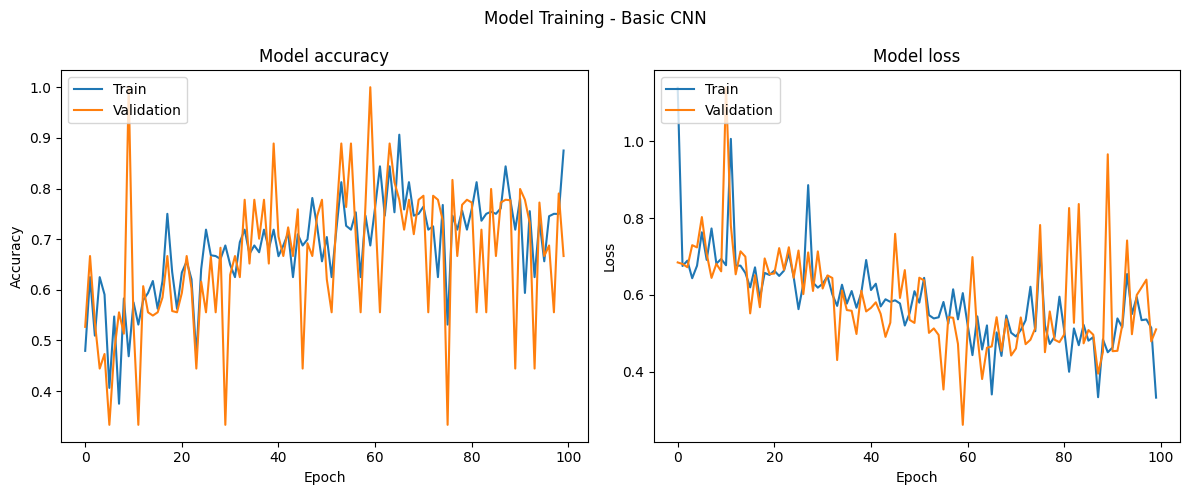

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.suptitle('Model Training - Basic CNN')
plt.tight_layout()
plt.show()


In [19]:
predictions = model.predict(test_images)
predictions = (predictions > 0.5)

prediction_csv(test_labels, predictions, 'Basic CNN')
print(classification_report(test_labels, predictions))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
              precision    recall  f1-score     support
0              0.853448  0.682759  0.758621  145.000000
1              0.738636  0.884354  0.804954  147.000000
accuracy       0.784247  0.784247  0.784247    0.784247
macro avg      0.796042  0.783556  0.781787  292.000000
weighted avg   0.795649  0.784247  0.781946  292.000000
78.42465753424658
      Modell Accuracy Precision Recall F1-Score                       Date
0  Basic CNN      78%       80%    78%      78% 2024-05-26 02:26:58.581761
              precision    recall  f1-score   support

           0       0.85      0.68      0.76       145
           1       0.74      0.88      0.80       147

    accuracy                           0.78       292
   macro avg       0.80      0.78      0.78       292
weighted avg       0.80      0.78      0.78       292



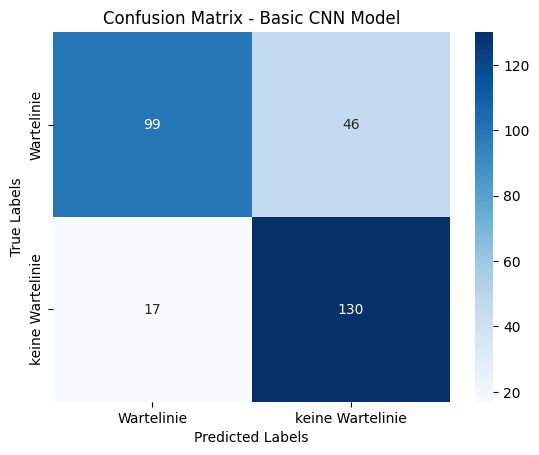

In [21]:
namelabels = {0: 'Wartelinie', 1: 'keine Wartelinie'}
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=namelabels.values(), yticklabels=namelabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Basic CNN Model')
plt.show()